In [1]:
# allows showing the tensorboard widget
%load_ext tensorboard
# reload imports on rerun
%load_ext autoreload

# set to 1 for cuda debugging
%set_env CUDA_LAUNCH_BLOCKING=0

env: CUDA_LAUNCH_BLOCKING=0


In [2]:
# show the tensorboard widget
%tensorboard --logdir lightning_logs

In [3]:
# enable import reloads
%autoreload 2

import pytorch_lightning as lightning

import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Subset
from sklearn.datasets import make_moons, make_circles

import numpy as np
import matplotlib.pyplot as plt

import pathlib

from rectflow import RectifyingFlow
from data import ProductSet, PairedDataset

import utils

In [4]:
plt.rc("figure", dpi=250)
plt.rc("legend", fontsize=6)

plots = pathlib.Path("plots")

plots.mkdir(parents=True, exist_ok=True)

In [5]:
accelerator = "gpu"
devices = 1

In [6]:
torch.autograd.set_grad_enabled(False)

In [7]:
n_train = 100000
n_val = 20000

In [8]:
def make_blobs(samples_per_blob: int = 100, *, centers: int = 8, radius: float = 10.0, std: float = 1.0, shuffle=True):
    """ Make 2D gaussian blobs distributed equally on a circle about the origin """
    phis = np.linspace(0, 2 * np.pi, num=centers + 1)[:-1]
    means = np.empty((centers, 2))
    means[:, 0] = radius * np.cos(phis)
    means[:, 1] = radius * np.sin(phis)

    samples = np.random.normal(means, std, size=(samples_per_blob, centers, 2))
    labels = np.resize(np.arange(centers), (samples_per_blob, centers))

    # flatten
    samples = samples.reshape(samples_per_blob * centers, 2)
    labels = labels.reshape(-1)

    if shuffle:
        sort = np.random.permutation(len(samples))
        samples = samples[sort, ...]
        labels = labels[sort, ...]

    return samples, labels

In [9]:
# features, labels = make_blobs(n_train // 4, centers=4)
# noise = np.random.standard_normal(features.shape)
# features = torch.from_numpy(features.astype(np.float32))
# noise = torch.from_numpy(noise.astype(np.float32))

# train_data = ProductSet(features, noise)

# features, labels = make_blobs(n_val  // 4, centers=4)
# noise = np.random.standard_normal(features.shape)
# features = torch.from_numpy(features.astype(np.float32))
# noise = torch.from_numpy(noise.astype(np.float32))

# val_data = ProductSet(features, noise)


features, labels = make_blobs(n_train // 4, centers=4, radius=20.0, std=2.0)
latent_features, latent_labels = make_blobs(n_train // 4, centers=4, radius=10.0, std=1.0)

features = torch.from_numpy(features.astype(np.float32))
latent_features = torch.from_numpy(latent_features.astype(np.float32))

train_data = PairedDataset(latent_features, features)


features, labels = make_blobs(n_val // 4, centers=4, radius=20.0, std=2.0)
latent_features, latent_labels = make_blobs(n_val // 4, centers=4, radius=10.0, std=1.0)

features = torch.from_numpy(features.astype(np.float32))
latent_features = torch.from_numpy(latent_features.astype(np.float32))

val_data = PairedDataset(latent_features, features)

len(train_data), len(val_data)

(100000, 20000)

In [10]:
# features, labels = make_moons(n_train, shuffle=True, noise=0.05)
# noise = np.random.standard_normal((n_train, 2))
# features = torch.from_numpy(features.astype(np.float32))
# noise = torch.from_numpy(noise.astype(np.float32))

# train_data = ProductSet(features, noise)
# # random_train_subset = Subset(train_data, indices=torch.randperm(len(train_data))[:2 * n_train])

# features, labels = make_moons(n_val, shuffle=True, noise=0.05)
# noise = np.random.standard_normal((n_val, 2))
# features = torch.from_numpy(features.astype(np.float32))
# noise = torch.from_numpy(noise.astype(np.float32))

# val_data = ProductSet(features, noise)
# # random_val_subset = Subset(val_data, indices=torch.randperm(len(val_data))[:2 * n_val])

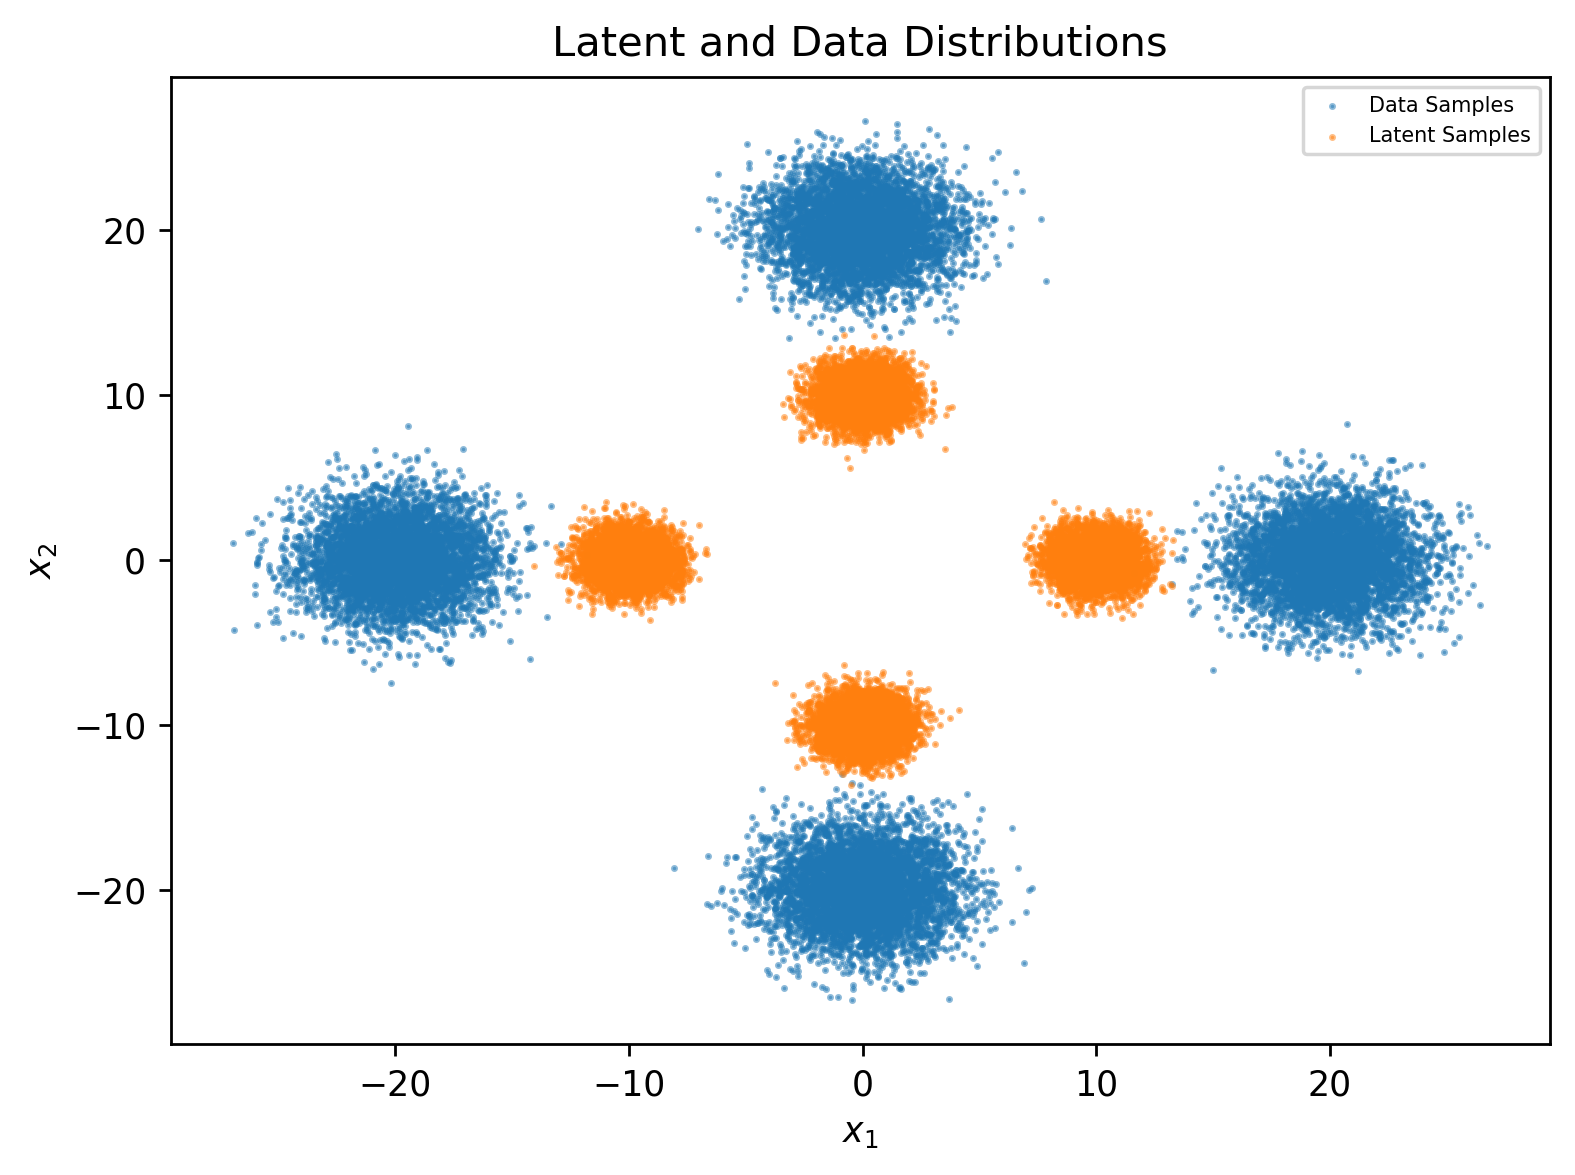

In [11]:
plt.scatter(features[:, 0], features[:, 1], s=1, alpha=0.5, c="C0", label="Data Samples")
plt.scatter(latent_features[:, 0], latent_features[:, 1], s=1, c="C1", alpha=0.5, label="Latent Samples")
plt.title("Latent and Data Distributions")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.tight_layout()
plt.savefig(plots / "data.png")

In [12]:
hparams = dict(
    input_shape=(2,),
    batch_size=1024,
    sample_size=32,
    learning_rate=1e-3,
    weight_decay=1e-2,
    integrator="rk45",
    network_widths=[128, 128, 128],
    activation="relu",
)

In [23]:
model = RectifyingFlow(train_data, val_data, test_data=None, **hparams)

In [24]:
trainer = lightning.Trainer(
    accelerator=accelerator,
    devices=devices,
    benchmark=True,
    max_epochs=100,
)

with torch.autograd.enable_grad():
    model.train()
    trainer.fit(model)

# best_model = model.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
# best_model.eval()

# model = best_model

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | network | Sequential | 33.8 K
---------------------------------------
33.8 K    Trainable params
0         Non-trainable params
33.8 K    Total params
0.135     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


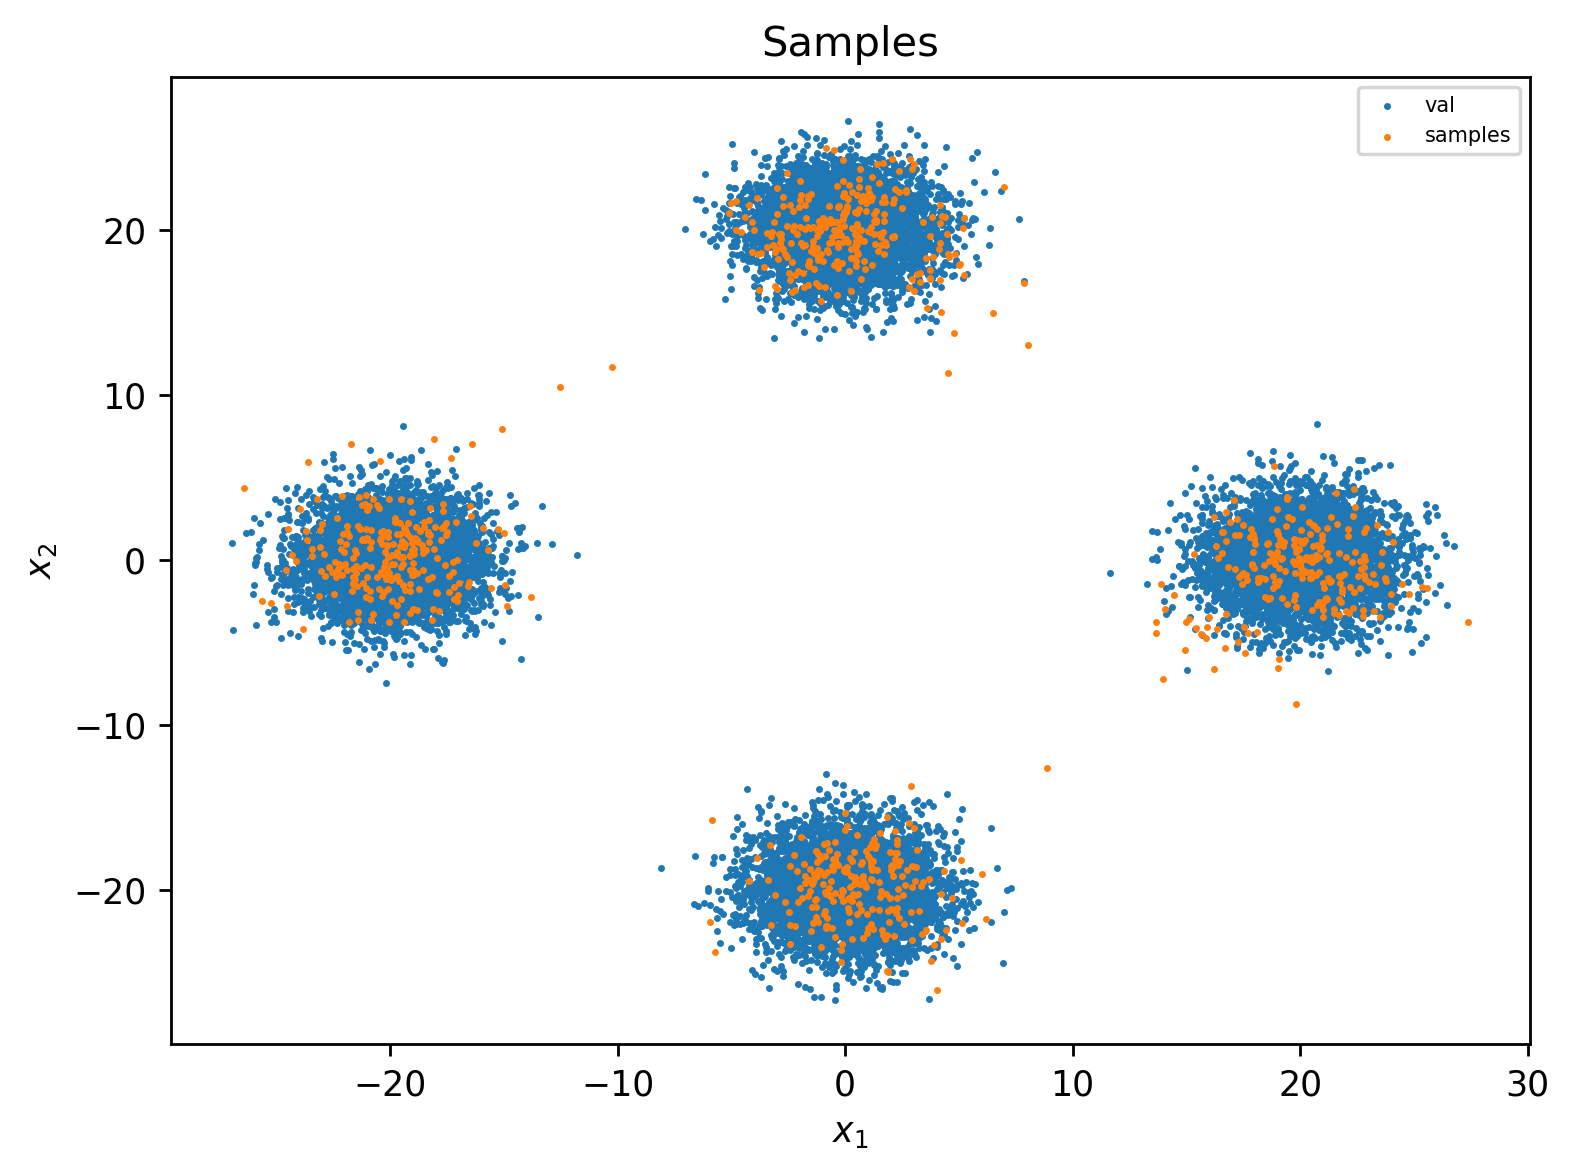

In [25]:
samples, _ = make_blobs(1000 // 4, centers=4, radius=10.0, std=1.0)
# samples = np.random.standard_normal((1000, 2))
samples = samples.astype(np.float32)
samples = torch.from_numpy(samples)
samples = model.forward(samples, steps=int(1e3))

plt.scatter(features[:, 0], features[:, 1], s=1, label="val")
# plt.xlim(plt.xlim())
# plt.ylim(plt.ylim())
plt.scatter(samples[:, 0], samples[:, 1], s=1, label="samples")
plt.legend()
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Samples")
plt.legend()

plt.tight_layout()
plt.savefig(plots / "samples.png")

In [26]:
ts = [0.5]

for t in ts:
    print(f"\rt={t:.2f}", end="")
    height, width = 500, 500
    xmin, xmax = -25, 25
    ymin, ymax = -25, 25

    x = np.linspace(xmin, xmax, width)
    y = np.linspace(ymin, ymax, height)

    yarrows, xarrows = 30, 30

    xx, yy = np.meshgrid(x, y)
    x, y = xx.flatten(), yy.flatten()
    xy = np.stack((x, y), axis=1)
    xy = torch.from_numpy(xy).to(torch.float32).to(model.device)
    
    time = t + torch.zeros(xy.shape[0], device=model.device)
    time = utils.unsqueeze_as(time, xy)

    v = model.velocity(xy, time=time)
    norm = np.linalg.norm(v, axis=-1)

    artist = plt.imshow(norm.reshape(height, width), extent=(x.min(), x.max(), y.min(), y.max()))
    plt.colorbar(artist, fraction=0.046, pad=0.04)

    x = np.linspace(xmin, xmax, xarrows)
    y = np.linspace(ymin, ymax, yarrows)

    xx, yy = np.meshgrid(x, y)
    x, y = xx.flatten(), yy.flatten()
    xy = np.stack((x, y), axis=1)
    xy = torch.from_numpy(xy).to(torch.float32).to(model.device)
    time = t + torch.zeros(xy.shape[0], device=model.device)
    time = utils.unsqueeze_as(time, xy)

    v = model.velocity(xy, time=time)

    plt.quiver(x, y, v[:, 0], v[:, 1], angles="xy", pivot="mid", color="white")

    plt.title(f"Learned Velocity Field at $t = {t:.04f}$")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")

    plt.tight_layout()
    path = plots / "quiver"
    path.mkdir(parents=True, exist_ok=True)
    plt.savefig(path / f"t={t}.png")
    plt.close()

print("Done.")

t=0.50Done.


In [27]:
samples, _ = make_blobs(1000 // 4, centers=4, radius=20.0, std=2.0)
# samples = np.random.standard_normal((1000, 2))
samples = samples.astype(np.float32)
samples = torch.from_numpy(samples)
samples = samples.to(model.device)
x = samples

steps = int(1e3)
time = torch.ones(x.shape[0], device=model.device)
time = utils.unsqueeze_as(time, x)
dt = torch.tensor(-1.0 / steps, device=model.device)
trajectories = [x.clone()]

for step in range(steps):
    x, time = model.integrator.step(f=model.velocity, x=x, t=time, dt=dt)
    trajectories.append(x.clone())

trajectories = torch.stack(trajectories)

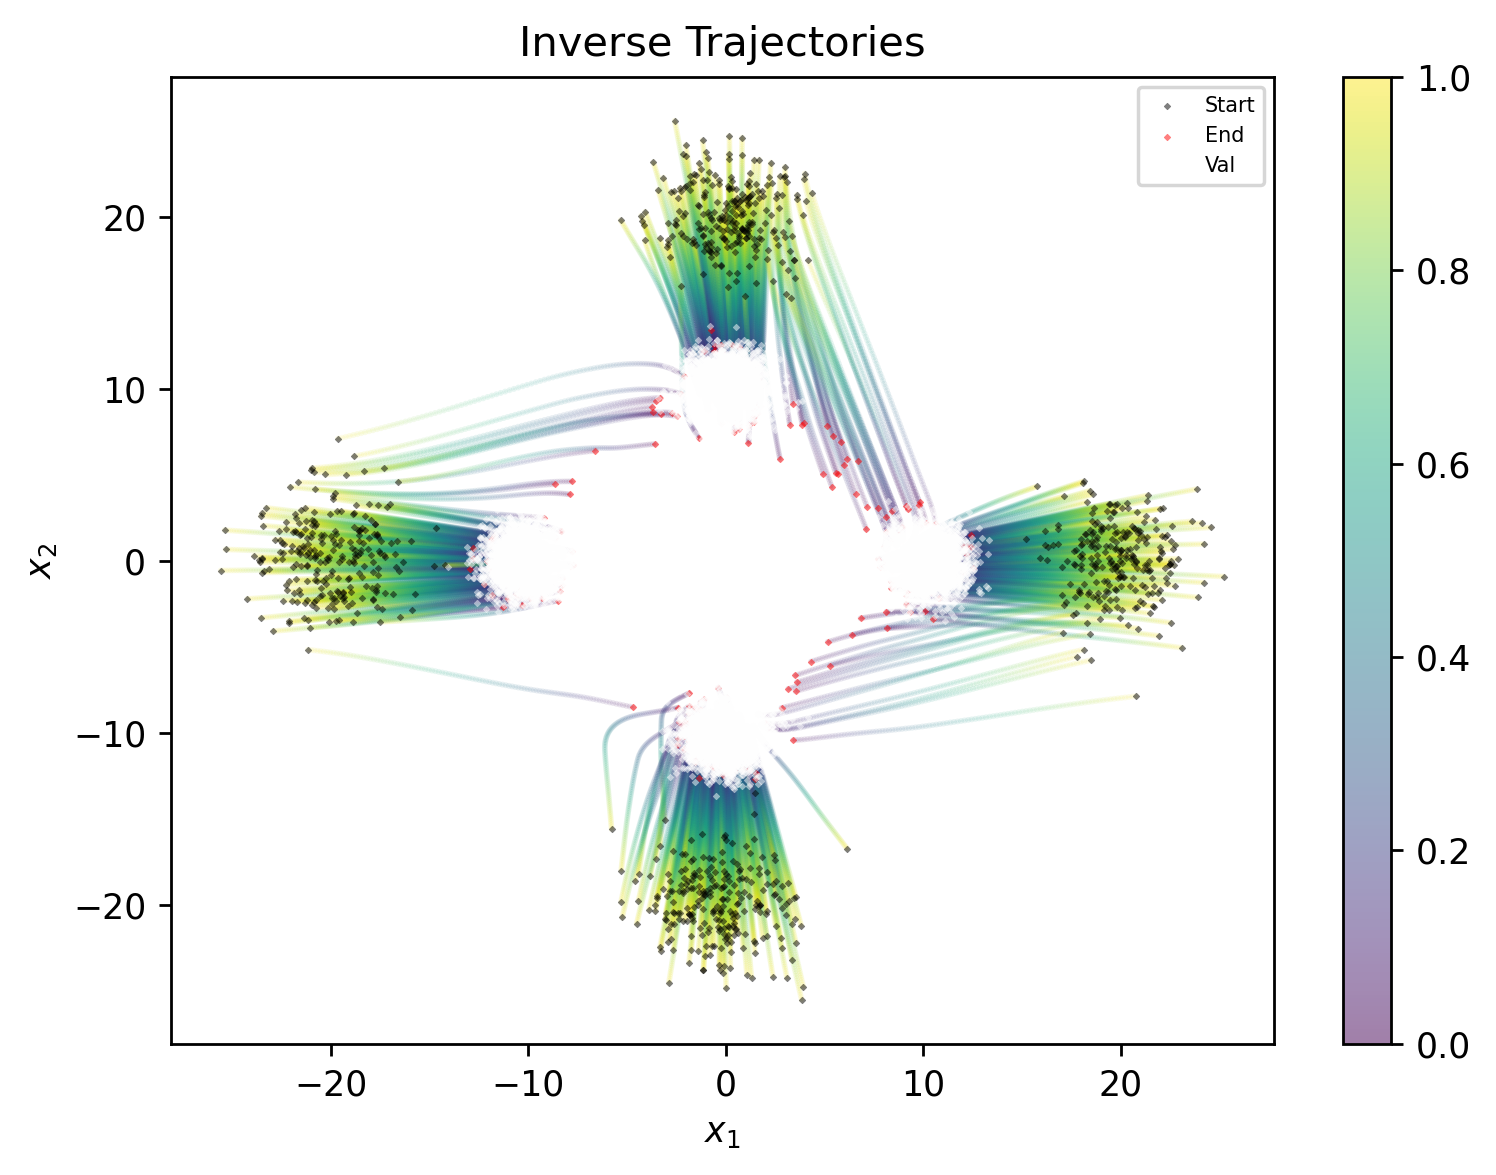

In [28]:
t = np.linspace(1, 0, steps + 1)
for i in range(len(samples)):
    plt.scatter(trajectories[::10, i, 0], trajectories[::10, i, 1], alpha=0.1, c=t[::10], s=0.5)

plt.scatter(trajectories[0, :, 0], trajectories[0, :, 1], alpha=0.5, marker="x", c="black", s=1, label="Start")
plt.scatter(trajectories[-1, :, 0], trajectories[-1, :, 1], alpha=0.5, marker="x", c="red", s=1, label="End")

plt.scatter(latent_features[:, 0], latent_features[:, 1], color="white", alpha=0.5, marker="x", s=1, label="Val")

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.legend()
plt.colorbar()
plt.title("Inverse Trajectories")

plt.tight_layout()
plt.savefig(plots / "inverse_trajectories.png")

In [29]:
samples, _ = make_blobs(1000 // 4, centers=4, radius=10.0, std=1.0)
samples = samples.astype(np.float32)
samples = torch.from_numpy(samples)
samples = samples.to(model.device)
x = samples

steps = int(1e3)
time = torch.zeros(x.shape[0], device=model.device)
time = utils.unsqueeze_as(time, x)
dt = torch.tensor(1.0 / steps, device=model.device)
trajectories = [x.clone()]

for step in range(steps):
    x, time = model.integrator.step(f=model.velocity, x=x, t=time, dt=dt)
    trajectories.append(x.clone())

trajectories = torch.stack(trajectories)

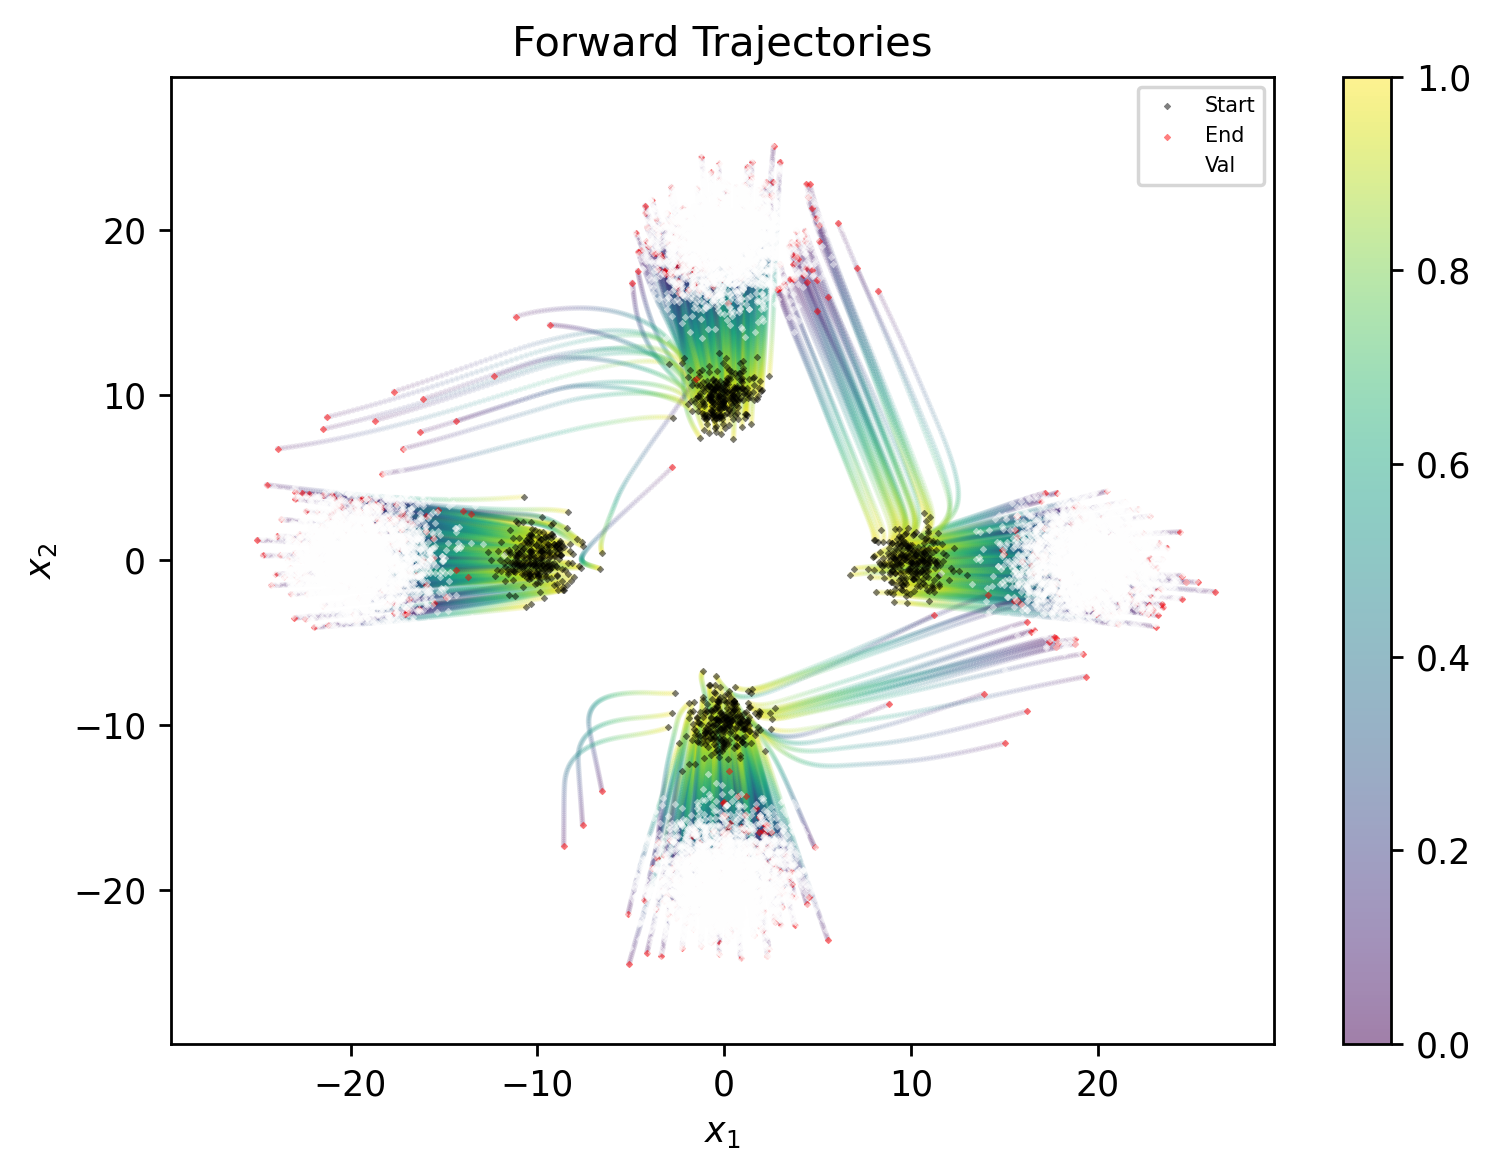

In [30]:
t = np.linspace(1, 0, steps + 1)
for i in range(len(samples)):
    plt.scatter(trajectories[::10, i, 0], trajectories[::10, i, 1], alpha=0.1, c=t[::10], s=0.5)

plt.scatter(trajectories[0, :, 0], trajectories[0, :, 1], alpha=0.5, marker="x", c="black", s=1, label="Start")
plt.scatter(trajectories[-1, :, 0], trajectories[-1, :, 1], alpha=0.5, marker="x", c="red", s=1, label="End")

plt.scatter(features[:, 0], features[:, 1], color="white", alpha=0.5, marker="x", s=1, label="Val")

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.legend()
plt.colorbar()
plt.title("Forward Trajectories")

plt.tight_layout()
plt.savefig(plots / "forward_trajectories.png")

In [31]:
# reflow: replace data by simulated flow
paired_set = model.train_data
z = paired_set.datasets[0]
x = paired_set.datasets[1]

# replace latent data with inverse pass
z = model.inverse(x, steps=int(1e3))

train_data = PairedDataset(z, x)
model.train_data = train_data

In [32]:
paired_set = model.val_data
z = paired_set.datasets[0]
x = paired_set.datasets[1]

z = model.inverse(x, steps=int(1e3))

val_data = PairedDataset(z, x)
model.val_data = val_data